In [1]:
#
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
%cd /Users/charlieturner/Documents/CountingBoats
from counting_boats.utils.area_coverage import is_inside
from counting_boats.utils.planet_utils import get_aois

aois = [
    ('peel', 'data/polygons/peel.json'),
    ('tangalooma', 'data/polygons/tangalooma.json'),
    ('south_bribie', 'data/polygons/south_bribie.json')
]


# load the data
data1 = pd.read_csv("visualisation/data/alex_boats.csv")
data1['date'] = pd.to_datetime(data1['date'], dayfirst=True)

data2 = pd.read_csv("visualisation/data/boat_counts_23_24.csv")
data2['date'] = pd.to_datetime(data2['date'], dayfirst=True)

data3 = pd.read_csv("visualisation/data/boat_counts_24.csv")
data3['date'] = pd.to_datetime(data3['date'], dayfirst=True)

data = pd.concat([data1, data2, data3]).sort_values('date').reset_index(drop=True)

data = data[data['AOI'] != 'unknown']

print("Date range:", data['date'].min(), data['date'].max())
date_range = pd.date_range(data['date'].min(), data['date'].max())
print("Number of days:" , len(date_range))
print("Days we have:", len(pd.unique(data['date'])))
# print the number of missing dates within that range
missing_dates = date_range[~date_range.isin(data['date'])]
print("Missing days:", len(missing_dates))

counts = data.groupby('date').size()

# plot the number of boats per day (marker size 5)
ax = counts.plot(x='date', y='count', style='o', figsize=(10, 6), markersize=2)
ax.set_xlabel("Date")
ax.set_ylabel("Number of boats")
ax.set_title("Number of boats per day")
plt.show()

In [ ]:
data.head()

In [ ]:
# break the data spatially into 3 clusters (ignoring AOIS)

X = data[['latitude', 'longitude']].values
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
data['cluster'] = kmeans.labels_
# get rid of the outliers (great barrier reef)
data = data[data['cluster'] == 0]

# now cluster again with 3 clusters
X = data[['latitude', 'longitude']].values
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
data['cluster'] = kmeans.labels_

# plot the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['longitude'], data['latitude'], c=data['cluster'], s=1)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial clusters")
plt.show()

# north-most cluster is south_bribie
# south-most cluster is peel
# middle cluster is tangalooma

# assign the AOI to each cluster
data.loc[data['cluster'] == 0, 'AOI'] = 'peel'
data.loc[data['cluster'] == 1, 'AOI'] = 'south_bribie'
data.loc[data['cluster'] == 2, 'AOI'] = 'tangalooma'

data.head()



In [ ]:
# Visualise the missing dates
dates_we_have = data['date'].value_counts().sort_index()
mask = np.isin(date_range, dates_we_have.index)
mask = mask.reshape(1, -1)
# visualise the mask 
fig, ax = plt.subplots()
ax.imshow(mask, aspect=500, cmap='gray')
x = np.linspace(0, len(date_range), 10)
ax.set_xticks(x)
ax.set_xticklabels([date_range[int(i-1)].strftime("%d-%m-%Y") for i in x], rotation=45)

plt.show()

In [ ]:
# Biggest run of consecutive dates we have
consecutive_dates = np.diff(np.where(np.diff(np.where(mask == 0)) == 1))
print("Longest run of consecutive dates we have:", consecutive_dates.max())

## Visualise some data spatially

In [ ]:
# work out some limits
x_min = data['longitude'].min()
x_max = data['longitude'].max()
y_min = data['latitude'].min()
y_max = data['latitude'].max()

# add a 5% margin to the limits
x_margin = 0.05 * (x_max - x_min)
y_margin = 0.05 * (y_max - y_min)
x_min -= x_margin
x_max += x_margin
y_min -= y_margin
y_max += y_margin

print(x_min, x_max, y_min, y_max)


In [ ]:

# plot all the boats
fig, ax = plt.subplots()
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
for aoi in data['AOI'].unique():
    aoi_data = data[data['AOI'] == aoi]
    ax.scatter(aoi_data['longitude'], aoi_data['latitude'], label=aoi, s=2)
ax.legend()
plt.show()

# *******************************
# This works but takes time
# *******************************

# Do an animation through the days boats
# import matplotlib.animation as animation
# fig, ax = plt.subplots()
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# sc = ax.scatter([], [])
# def update(day):
#     day_data = data[data['date'] == dates_we_have.index[day]]
#     sc.set_offsets(day_data[['longitude', 'latitude']])
#     # set the title to the date
#     ax.set_title(dates_we_have.index[day])
#     return sc,
# ani = animation.FuncAnimation(fig, update, frames=len(dates_we_have), interval=100)

# ani.save('data/boat_animation.mp4', writer='ffmpeg', fps=4)


In [ ]:
# Peel island is just all entries with AOI = peelIsland
AOI = 'peel'
aoi_data = data[data['AOI'] == AOI]
print("We have {} entries over {} days for {}".format(len(aoi_data), len(pd.unique(aoi_data['date'])), AOI))
aoi_data.head()
# print the range of dates we have
print(aoi_data['date'].min(), aoi_data['date'].max())


# distribution of day of week
aoi_data['day_of_week'] = aoi_data['date'].dt.dayofweek
day_of_week = aoi_data['day_of_week'].value_counts().sort_index()
# normalise based on the number of days we have
print(day_of_week)
fig, ax = plt.subplots()
day_of_week.plot(kind='bar', ax=ax)
ax.title.set_text('Distribution of day of week of aoi availability')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()


In [ ]:
# Load the weather data
weather = pd.read_csv("visualisation/data/weather.csv")
# convert the date to a datetime
weather['date'] = pd.to_datetime(weather['YYYY-MM-DD'])
weather = weather.drop(columns=['YYYY-MM-DD', 'metadata'])
weather.head()


# Interpolation

In [ ]:
# Build the dataset for machine learning:
# Put together the weather and boat data, lets start with count per day
# First dataset: date, count, daily_rain, max_temp, min_temp 

peel_grouped = aoi_data.groupby('date')
peel_counts = peel_grouped.size()
peel_counts = peel_counts.reset_index()
peel_counts.columns = ['date', 'count']

weather_columns = ['date', 'daily_rain', 'max_temp', 'min_temp']
weather = weather[weather_columns]

data = pd.merge(peel_counts, weather, on='date', how='inner')
data['day_of_week'] = data['date'].dt.dayofweek
data['season'] = (data['date'].dt.month % 12 + 3) // 3
data['year'] = data['date'].dt.year
# one hot encode the date data
data = pd.get_dummies(data, columns=['day_of_week', 'season', 'year'], drop_first=True, dtype=int)
print("Observations:", data.shape[0])

# normalise the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[['daily_rain', 'max_temp', 'min_temp']] = scaler.fit_transform(data[['daily_rain', 'max_temp', 'min_temp']])

data.head()

In [ ]:
# Now we can build a simple linear regression model to predict the count of boats

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

x_cols = [col for col in data.columns if col not in ['date', 'count']]

X = data[x_cols]

y = data['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=71)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
err = rmse(y_test, y_pred)
print("Error:", err)

# plot the predictions
def plot_predictions(y_test, y_pred):
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_pred)
    ax.set_xlabel('True count')
    ax.set_ylabel('Predicted count')
    # grid
    ax.grid(True)
    # add the line y = x
    ax.plot([0, y_test.max()], [0, y_test.max()], color='black')
    # make the aspect ratio equal
    ax.set_aspect('equal', adjustable='box')
    plt.show()

plot_predictions(y_test, y_pred)

# plot predictions for the training data
y_pred_train = model.predict(X_train)

Err = rmse(y_train, y_pred_train)
print("Error:", Err)

plot_predictions(y_train, y_pred_train)




In [ ]:
# Plot a heatmap of the correlation matrix
import seaborn as sns
corr = data.corr()
fig, ax = plt.subplots()
sns.heatmap(corr.abs(), ax=ax)
plt.show()


In [ ]:
# Try a more complex model like RF
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
err = rmse(y_test, y_pred)

print("Test Error RMSE:", err)

# plot the predictions

# plot_predictions(y_test, y_pred)
y_pred_train = model.predict(X_train)
Err = rmse(y_train, y_pred_train)
print("Train Error RMSE:", Err)




In [ ]:
# Try a neural network
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(32, 64, 128, 256, 128, 64, 32), random_state=42, max_iter=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
err = rmse(y_test, y_pred)
print("Test Error RMSE:", err)
y_train_pred = model.predict(X_train)
Err = rmse(y_train, y_train_pred)
print("Train Error RMSE:", Err)
# plot_predictions(y_test, y_pred)

In [ ]:
# Try a simple fully connected neural network
import torch

class BoatModel(torch.nn.Module):
    def __init__(self, input_size):
        super(BoatModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 64)
        self.fc2 = torch.nn.Linear(64, 128)
        self.fc3 = torch.nn.Linear(128, 256)
        self.fc4 = torch.nn.Linear(256, 128)
        self.fc5 = torch.nn.Linear(128, 64)
        self.fc6 = torch.nn.Linear(64, 32)
        self.fc7 = torch.nn.Linear(32, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = self.fc7(x)
        return x

class VarPenalisedMSELoss(torch.nn.Module):
    def __init__(self, penalty=0.1):
        super(VarPenalisedMSELoss, self).__init__()
        self.penalty = penalty
    def forward(self, y_pred, y_true):
        loss = torch.mean((y_pred - y_true) ** 2)
        var = torch.var(y_pred)
        return loss + self.penalty * var
    

model = BoatModel(X_train.shape[1])
criterion = VarPenalisedMSELoss(penalty=0)


optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)

# oversample high y values to balance the dataset 
y_bins = np.linspace(y_train.min(), y_train.max(), 10)
count = np.histogram(y_train, bins=y_bins)[0]
weights = 1 / (count+1)
sample_weights = weights[(np.digitize(y_train-1, y_bins) - 1)]
sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(y_train), replacement=True)
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=round(X_train.shape[0]/2),
                                           sampler=sampler)


X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

best_after = 1000
best_epoch = 0
best_val_loss = np.inf
best_model = None

losses = []
val_losses = []

# print out if torch is using mps
print(torch.cuda.is_available())

for epoch in range(100000):
    optimizer.zero_grad()
    for X_batch, y_batch in train_loader:
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
    optimizer.step()
    with torch.no_grad():
        val_pred = model(X_test_tensor)
        val_loss = criterion(val_pred, y_test_tensor)
        if epoch % 1000 == 0:
            print(f"=== Epoch {epoch:7} loss: {loss.item():4.3f} val_loss: {val_loss.item():4.3f} Best val_loss: {best_val_loss:4.3f} at epoch {best_epoch:7} ===", end="\r")
        losses.append(loss.item())
        val_losses.append(val_loss.item())
        if val_loss < best_val_loss and epoch > best_after:
            best_val_loss = val_loss
            best_epoch = epoch
            best_model = BoatModel(X_train.shape[1])
            best_model.load_state_dict(model.state_dict())
        if epoch - best_epoch > 10000:
            print(f"\nStopping early at epoch {epoch}")
            break
print()


y_pred = best_model(X_test_tensor)
err = rmse(y_test_tensor.detach().numpy(), y_pred.detach().numpy())
print("Validation Error RMSE:", err)

plot_predictions(y_test_tensor.detach().numpy(), y_pred.detach().numpy())

# plot predictions over training data
y_pred = best_model(X_train_tensor)
err = rmse(y_train_tensor.detach().numpy(), y_pred.detach().numpy())
print("Training Error RMSE:", err)

plot_predictions(y_train_tensor.detach().numpy(), y_pred.detach().numpy())

In [ ]:
# Use ARIMA to estimate the number of boats on any given day. 
# Then -> Use a spatial density model to predict where those boats are likely to be.

# Essentially what we want is:
# Overall: A good estimate for the number of boats within each small region of the bay on any given day.
# To achieve this we need:
#   A model that can predict the number of boats in a given area on a given day
#   A model that can determine the spatial distribution of those boats
#   Either/both of these models may take into account any factors such as:
#   - Weather
#   - Day of week
#   - Season
#   - Spatial distribution of boats on previous days
#   - Spatial distribution of boats in other areas on the same day

!pwd
%cd ./visualisation

# SARIMA / Kriging Ensemble

C:\ML_software
        date class   latitude   longitude confidence         AOI
0 2016-09-26   0.0 -27.468701  153.416909    0.76708  peelIsland
1 2016-09-26   0.0 -27.470263  153.414452   0.690329  peelIsland
2 2016-09-26   0.0 -27.516103  153.376083   0.621974  peelIsland
3 2016-09-26   0.0 -27.501949  153.372815   0.699359  peelIsland
4 2016-09-26   0.0 -27.504139  153.363919   0.631398  peelIsland
(18,)
dict_keys(['26-09-2016', '08-04-2017', '17-05-2017', '01-06-2017', '03-06-2017', '05-06-2017', '24-06-2017', '02-07-2017', '03-07-2017', '08-07-2017', '13-07-2017', '20-07-2017', '22-07-2017', '28-07-2017', '12-08-2017', '06-09-2017', '09-09-2017', '22-09-2017', '23-09-2017', '29-09-2017', '04-10-2017', '12-10-2017', '21-10-2017', '25-10-2017', '28-10-2017', '02-11-2017', '06-12-2017', '23-12-2017', '07-01-2018', '12-01-2018', '14-01-2018', '18-01-2018', '11-02-2018', '13-02-2018', '25-02-2018', '27-02-2018', '15-03-2018', '30-03-2018', '09-04-2018', '16-04-2018', '23-04-2018', '10-

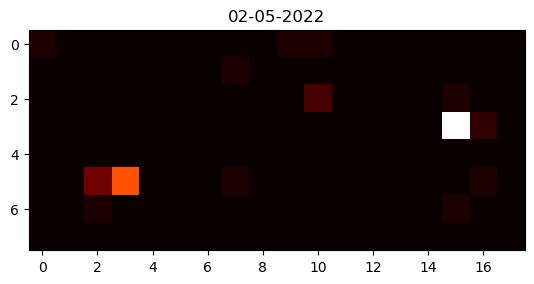

[[ 36   8  15  12   6   8   8   1   4   3  17   4   0   0   0   1   8  22]
 [  1  12  38  40  21  20  14   8  11  23  42  75  20  13  63  30  80 127]
 [  5   0  16  23  29  33  15  31  16  21  88  28  58  25  18  33   1   0]
 [  1   0   4  32  24  27  31  18  11   2  56   3   0  57  56 178 120   0]
 [  0   0   2  40  66  40  50  41  19   2   0 128 136  72  29  39   0   0]
 [  0   3 167 179  54  57  47  62  44  14   3 145  80  24  35 133 115   0]
 [  0   0  98  40   5  10  22  32  52  60  54  72  41  59  46  27  76   0]
 [  0   0   0   0   0   3   8   9  12  16  43  45  29  14   7  14  65   0]]
3 5


In [7]:
# build the dataset
%cd C:\ML_software
from counting_boats.utils.image_cutting_support import latlong2coord
import math

data1 = pd.read_csv("visualisation\\data\\alex_boats.csv")
data1.loc['date'] = pd.to_datetime(data1['date'], dayfirst=True)
data = data1.copy()[data1['AOI'] == 'peelIsland']
# sort by date
data['date'] = pd.to_datetime(data['date'], dayfirst=True)
data = data.sort_values('date').reset_index(drop=True)
print(data.head())
# convert lat/long into epsg:32756
data['x'], data['y'] = latlong2coord(data['longitude'], data['latitude'])
# break dataset into a grid
grid_size = 1000 # meters
x_min = math.floor(data['x'].min())
x_max = math.ceil(data['x'].max())
y_min = math.floor(data['y'].min())
y_max = math.ceil(data['y'].max())
# create the grid
x_grid = np.arange(x_min, x_max, grid_size)
print(x_grid.shape)
y_grid = np.arange(y_min, y_max, grid_size)
# from 00 -> {max_x, max_y}, add location to each point
data['grid_x'] = np.digitize(data['x'], x_grid)
data['grid_y'] = np.digitize(data['y'], y_grid)
datasets = {}
for date in pd.unique(data['date']):
    # numpy.datetime64 -> DD-MM-YYYY
    date_str = pd.to_datetime(date).strftime("%d-%m-%Y")
    date_data = data[data['date'] == date]
    grid = np.zeros((len(y_grid), len(x_grid) ))
    for i, row in date_data.iterrows():
        grid[row['grid_y']-1,row['grid_x']-1 ] += 1
    # need to flip the grid vertically so that x, y is relative to top left going down
    grid = np.flip(grid, axis=0)
    datasets[date_str] = grid
print(datasets.keys())

# Pick a random day and imshow
import matplotlib.pyplot as plt
day = np.random.choice(list(datasets.keys()))
print(day)
plt.imshow(datasets[day], cmap='hot')
plt.title(day)
plt.show()

all_grids = np.stack(list(datasets.values()))

# find the grid cell with the most non-zero entries
non_zero = np.count_nonzero(all_grids, axis=0)
print(non_zero)
# find the x and y
max_y, max_x = np.unravel_index(np.argmax(non_zero), non_zero.shape)
print(max_x, max_y)




# Time Series - SARIMA
Over time, we assume that the data in each grid pixel can be modelled by a SARIMA model. Fit a separate SARIMA model for each pixel. There isn't data every day, so SARIMA should deal with that

In [10]:
import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

all_grids = np.stack(list(datasets.values()))
dates = list(datasets.keys())
date_range = pd.date_range(dates[0], dates[-1])
print(len(date_range), "start:", date_range[0], "end:", date_range[-1])


2345 start: 2016-09-26 00:00:00 end: 2023-02-26 00:00:00


(199, 8, 18)
[nan nan nan ... nan nan nan]
179


(array([49., 37., 30., 33., 27., 16.,  5.,  0.,  1.,  1.]),
 array([ 0. ,  3.2,  6.4,  9.6, 12.8, 16. , 19.2, 22.4, 25.6, 28.8, 32. ]),
 <BarContainer object of 10 artists>)

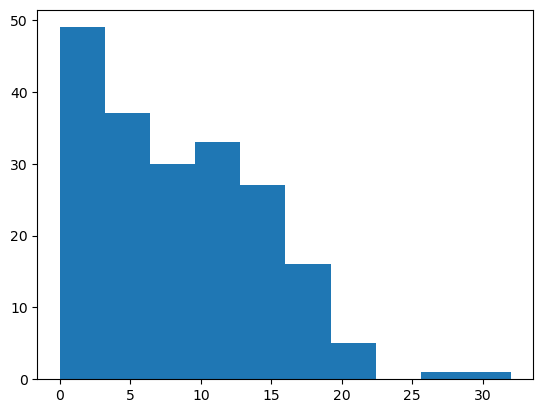

In [48]:

print(all_grids.shape) # days, y, x
# fit a SARIMA model to each grid cell
# start with just (3, 5)
data = np.zeros((len(date_range)))
data[:] = np.nan
print(data)

for idx, date in enumerate(date_range):
    datestr = date.strftime("%d-%m-%Y")
    if datestr in dates:
        date_id = dates.index(datestr)
        data[idx] = all_grids[date_id, 5, 3]
print((data > 0).sum())
plt.hist(data)

In [41]:
# fit the model to the data, lets say theres a weekly seasonality
model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 53))
model_fit = model.fit()

c:\Users\turner30\AppData\Local\miniconda3\envs\Boats\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\turner30\AppData\Local\miniconda3\envs\Boats\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


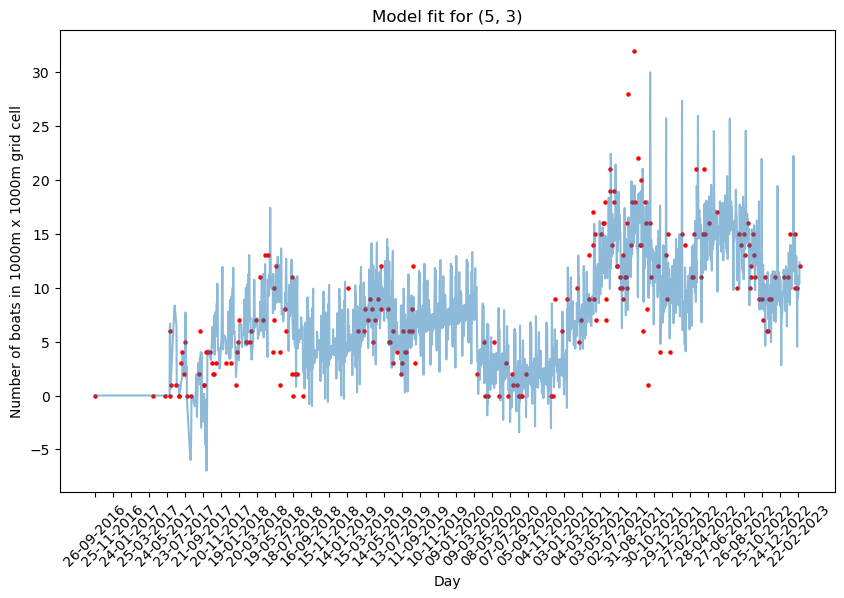

In [51]:
# show the model fit for a random grid cell which has non-zero values over time
y = 5
x = 3
# print(model_fit.summary())
plt.figure(figsize=(10, 6))
# plot data with circles
plt.scatter(range(len(data)), data, s=5, color='red')
plt.plot(model_fit.fittedvalues, alpha=0.5)
plt.xlabel("Day")
plt.ylabel("Number of boats in 1000m x 1000m grid cell")
plt.title(f"Model fit for ({y}, {x})")
# put the dates on the x axis (every 2 months)
plt.xticks(range(0, len(date_range), 60), [date.strftime("%d-%m-%Y") for date in date_range[::60]], rotation=45)



plt.show()





# Spatial Part - Kriging
Despite having a SARIMA for each grid cell, it is arguably also useful to incorporate spatial information into the model. This will allow us to estimate grid cells based on their 
surrounding cells (if available). 

In [58]:

# learn a spatial model of the number of boats in each grid cell relating to its neighbours
# using kriging
from skgstat import OrdinaryKriging, Variogram

# V = Variogram(coordinates=np.array([[0, 0], [1, 1]]), values=np.array([0, 1]))
coords = np.random.randint(0, 500, (300, 2))
print(coords)





[[116 178]
 [452 333]
 [455 272]
 [111 116]
 [451 374]
 [ 63  61]
 [120  84]
 [ 86 107]
 [360  63]
 [324 129]
 [498 261]
 [ 11 159]
 [385 436]
 [259 401]
 [185 104]
 [283 481]
 [365 209]
 [172 265]
 [267 307]
 [350 483]
 [ 36 256]
 [106  21]
 [301 160]
 [178 396]
 [205  54]
 [429 110]
 [158 441]
 [199 380]
 [155 284]
 [329 375]
 [471 263]
 [268 448]
 [287  95]
 [258 499]
 [301 260]
 [307 394]
 [454 382]
 [469 404]
 [ 32 439]
 [454 163]
 [163  52]
 [ 62 234]
 [340 301]
 [337 212]
 [ 72 116]
 [ 52 170]
 [269 360]
 [131 352]
 [153 440]
 [ 56 371]
 [ 38 128]
 [377 309]
 [470 135]
 [314 332]
 [426 344]
 [428 183]
 [179  90]
 [ 50 439]
 [237 160]
 [289  93]
 [ 91 399]
 [199  90]
 [181 373]
 [274 295]
 [494 451]
 [124 337]
 [231  59]
 [ 90 334]
 [100  18]
 [184  86]
 [439 360]
 [ 34 429]
 [434 401]
 [104 171]
 [233 490]
 [ 96 215]
 [418 475]
 [333 225]
 [255 306]
 [272 173]
 [ 45 185]
 [ 41 253]
 [220 459]
 [441  11]
 [494  68]
 [316 338]
 [129 468]
 [ 28 102]
 [445 470]
 [296 275]
 [ 29 153]

# AUTOENCODER

In [ ]:
# Try a similar thing, but using an AutoEncoder
# Method: 
#   - Train an autoencoder to take the grid of data and weather/any other features, and output the grid of data
#   - Can then use the autoencoder to predict the grid, given only the weather/any other features, or partial grid data
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

class TemporalGridDataset(Dataset):
    def __init__(self, grids, features, seq_length):
        self.grids = grids
        self.features = features
        self.seq_length = seq_length

    def __len__(self):
        return len(self.grids) - self.seq_length + 1

    def __getitem__(self, idx):
        grids_seq = self.grids[idx:idx + self.seq_length]
        features_seq = self.features[idx:idx + self.seq_length]
        return grids_seq, features_seq

class LSTMAutoEncoder(nn.Module):
    def __init__(self, grid_dim, feature_dim, hidden_dim, seq_length):
        super(LSTMAutoEncoder, self).__init__()
        self.seq_length = seq_length
        self.hidden_dim = hidden_dim
        self.grid_dim = grid_dim

        # LSTM Encoder
        self.lstm_encoder = nn.LSTM(input_size=grid_dim + feature_dim, hidden_size=hidden_dim, batch_first=True)
        # LSTM Decoder
        self.lstm_decoder = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, grid_dim)
        self.relu = nn.ReLU()

    def forward(self, grids, features):
        batch_size = grids.size(0)
        
        # Concatenate grids and features
        x = torch.cat((grids.float(), features.float()), dim=2 )

        # LSTM Encoder
        _, (hidden, _) = self.lstm_encoder(x)

        # Repeat the hidden state for each time step in the sequence for the decoder
        decoder_input = hidden.repeat(self.seq_length, 1, 1).permute(1, 0, 2)

        # LSTM Decoder
        decoder_output, _ = self.lstm_decoder(decoder_input)

        # Apply fully connected layers to the output of the LSTM Decoder
        decoded = self.relu(self.fc1(decoder_output))
        decoded = self.fc2(decoded)

        return decoded



In [ ]:

# Get data

boats = pd.read_csv("data/boat_detections.csv")
boats['date'] = pd.to_datetime(boats['date'], dayfirst=True)
date_range = pd.date_range(boats['date'].min(), boats['date'].max())
all_dates = pd.DataFrame(date_range, columns=['date'])
boats = all_dates.merge(boats, on='date', how='right')
print(boats)


weather =  pd.read_csv("data/weather.csv")
weather['date'] = pd.to_datetime(weather['YYYY-MM-DD'])

# Get the data in the right format
data = boats.merge(weather[['date', 'daily_rain', 'max_temp']], on='date', how='inner')
print(data.head())
# do the grids
long_range = data['longitude'].max() - data['longitude'].min()
lat_range = data['latitude'].max() - data['latitude'].min()
grid = 10
data['x'] = ((data['longitude'] - data['longitude'].min()) / long_range * grid).astype(int)
data['y'] = ((data['latitude'] - data['latitude'].min()) / lat_range * grid).astype(int)
data['location'] = data['x'] + (data['y'] * 10)
data_grouped = data.groupby(['date', 'location']).size().reset_index()
print(data_grouped.head())
data_grouped.columns = ['date', 'location', 'value']
data_wide = data_grouped.pivot(index='date', columns='location', values='value')
data_wide = data_wide.fillna(-1) # -1 for unknown

grids = data_wide.values
features = data[['daily_rain', 'max_temp']].values

seq_length = 7  # Sequence length (e.g., one week)
grid_size = grids.shape[1] # max 100 (some are empty in all data so less)
feature_dim =  features.shape[1] # Rain, max temp, season of year * 3
hidden_dim = 128




# Create DataLoader
dataset = TemporalGridDataset(grids, features, seq_length)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# train test split 0.8
train_grids = np.zeros((int(len(grids) * 0.8), grid_size))
train_features = np.zeros((int(len(grids) * 0.8), feature_dim))
test_grids = np.zeros((len(grids) - int(len(grids) * 0.8), grid_size))
test_features = np.zeros((len(grids) - int(len(grids) * 0.8), feature_dim))

i = 0
for batch_grids, batch_features in dataloader:
    if i < int(len(grids) * 0.8):
        train_grids[i] = batch_grids[0, 0, :].numpy()
        train_features[i] = batch_features[0, 0, :].numpy()
    else:
        test_grids[i - int(len(grids) * 0.8)] = batch_grids[0, 0, :].numpy()
        test_features[i - int(len(grids) * 0.8)] = batch_features[0, 0, :].numpy()
    i += 1

print (train_grids.shape, train_features.shape, test_grids.shape, test_features.shape)
dataset = TemporalGridDataset(train_grids, train_features, seq_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

test_dataset = TemporalGridDataset(test_grids, test_features, seq_length)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Initialize the model, loss function, and optimizer
model = LSTMAutoEncoder(grid_dim=grid_size, feature_dim=feature_dim, hidden_dim=hidden_dim, seq_length=seq_length)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
save_best_after = 50
best_val_loss = np.inf
best_model = None
best_epoch = 0
num_epochs = 2000

for epoch in range(num_epochs):
    for batch_grids, batch_features in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_grids, batch_features)
        loss = criterion(outputs, batch_grids.float())
        loss.backward()
        optimizer.step()
        # test
        if epoch > save_best_after:
            with torch.no_grad():
                for test_grids, test_features in test_dataloader:
                    test_outputs = model(test_grids, test_features)
                    test_loss = criterion(test_outputs, test_grids.float())
                    if test_loss < best_val_loss:
                        best_epoch = epoch
                        best_val_loss = test_loss
                        best_model = LSTMAutoEncoder(grid_dim=grid_size, feature_dim=feature_dim, hidden_dim=hidden_dim, seq_length=seq_length)
                        best_model.load_state_dict(model.state_dict())

            
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {test_loss.item():.4f}', end='\r')
print()

print("Training complete!")
print(f"Best Validation Loss: {best_val_loss.item():.4f} at epoch {best_epoch}")

# predict on test data
grid, feature = next(iter(test_dataloader))
output = best_model(grid, feature)
# imshow the predictions, but: remember that the columns of the prediction 
# are not 1-100. Have to fill in missing columns with 0
output = output.squeeze().detach().numpy()
output = output.reshape((seq_length, 10, 10))
output = output[-1, :, :]
plt.imshow(output)




# print out the model architecture
print(model)
